In [1]:
%matplotlib inline
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sns.set_theme(style='white', palette='muted', font_scale=1.15)

In [2]:
class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            $$\pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))$$
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s

In [3]:
class CWT(nn.Module):
    def __init__(
        self,
        dj=0.6, #0.0625,
        dt=10/32,
        wavelet=Morlet(),
        fmin: int = 20,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
        hop_length: int = 1,
    ):
        super().__init__()
        self.wavelet = wavelet

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, hop_length)
        # self.padding = 0  # "same"

        self._scale_minimum = 2 #self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = [2, 4, 8, 16]#32, 64, 128, 256, 512]
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    # def compute_minimum_scale(self):
    #     """
    #     Choose s0 so that the equivalent Fourier period is 2 * dt.
    #     See Torrence & Combo Sections 3f and 3h.
    #     :return: float, minimum scale level
    #     """
    #     dt = self.dt

    #     def func_to_solve(s):
    #         return self.wavelet.fourier_period(s) - 2 * dt

    #     return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # M = np.log2(512) * scale / self.dt
            print(f'Number of points needed to capture wavelet with scale {scale}: {M}')
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))
        self._pad_filters()
        return self._filters

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        print(f'Filter length: {filter_len}')
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0] + 1)# // 2
            padded_filters.append(nn.functional.pad(f, (pad, 0)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
        # See comment by tez6c32
        # https://www.kaggle.com/anjum48/continuous-wavelet-transform-cwt-in-pytorch/comments#1499878
        # wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank

    # def forward(self, x):
    #     """Compute CWT arrays from a batch of multi-channel inputs

    #     Args:
    #         x (torch.tensor): Tensor of shape (batch_size, channels, time)

    #     Returns:
    #         torch.tensor: Tensor of shape (batch_size, channels, widths, time)
    #     """
    #     if self.signal_length is None:
    #         self.signal_length = x.shape[-1]
    #         self.channels = x.shape[-2]
    #         self._scales = self.compute_optimal_scales()
    #         self._kernel = self._build_wavelet_bank()

    #         if self._kernel.is_complex():
    #             self._kernel_real = self._kernel.real
    #             self._kernel_imag = self._kernel.imag

    #     x = x.unsqueeze(1)

    #     if self._kernel.is_complex():
    #         if (
    #             x.dtype != self._kernel_real.dtype
    #             or x.device != self._kernel_real.device
    #         ):
    #             self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
    #             self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

    #         # Strides > 1 not yet supported for "same" padding
    #         # output_real = nn.functional.conv2d(
    #         #     x, self._kernel_real, padding=self.padding, stride=self.stride
    #         # )
    #         # output_imag = nn.functional.conv2d(
    #         #     x, self._kernel_imag, padding=self.padding, stride=self.stride
    #         # )
    #         output_real = conv2d_same(x, self._kernel_real, stride=self.stride)
    #         output_imag = conv2d_same(x, self._kernel_imag, stride=self.stride)
    #         output_real = torch.transpose(output_real, 1, 2)
    #         output_imag = torch.transpose(output_imag, 1, 2)

    #         if self.output_format == "Magnitude":
    #             return torch.sqrt(output_real ** 2 + output_imag ** 2)
    #         else:
    #             return torch.stack([output_real, output_imag], -1)

    #     else:
    #         if x.device != self._kernel.device:
    #             self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

    #         # output = nn.functional.conv2d(
    #         #     x, self._kernel, padding=self.padding, stride=self.stride
    #         # )
    #         output = conv2d_same(x, self._kernel, stride=self.stride)
    #         return torch.transpose(output, 1, 2)

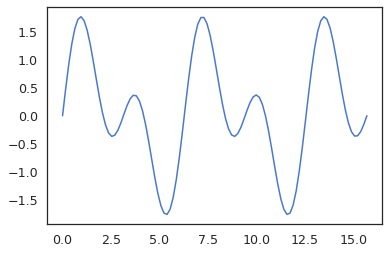

In [4]:
x = np.linspace(0, 5*np.pi, 100)
y = np.sin(x) + np.sin(2*x)
plt.plot(x, y)
plt.show()

In [5]:
pycwt = CWT()

In [6]:
filters = pycwt._build_filters()
len(filters)

Number of points needed to capture wavelet with scale 2: 64.0
Number of points needed to capture wavelet with scale 4: 128.0
Number of points needed to capture wavelet with scale 8: 256.0
Number of points needed to capture wavelet with scale 16: 512.0
Filter length: 511


4

In [7]:
real_filters = []
for f in filters:
    print(torch.real(f).shape)
    real_filters.append(torch.real(f))

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])


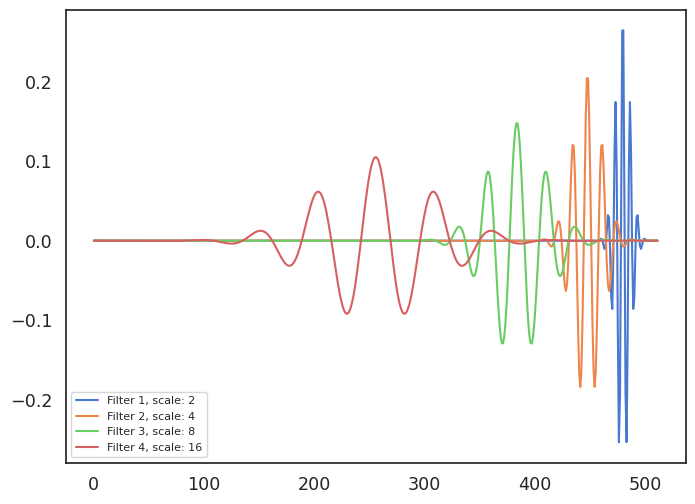

In [8]:
plt.figure(figsize=(8, 6), dpi=100)
for i, (rf, scale) in enumerate(zip(real_filters, [2, 4, 8, 16])):
    plt.plot(rf.numpy(), label=f'Filter {i+1}, scale: {scale}')
plt.legend(loc='lower left', fontsize=8)
plt.show()

In [9]:
bank = pycwt._build_wavelet_bank()
bank.shape

Number of points needed to capture wavelet with scale 2: 64.0
Number of points needed to capture wavelet with scale 4: 128.0
Number of points needed to capture wavelet with scale 8: 256.0
Number of points needed to capture wavelet with scale 16: 512.0
Filter length: 511


torch.Size([4, 1, 1, 512])

In [10]:
torch.squeeze(bank).shape

torch.Size([4, 512])

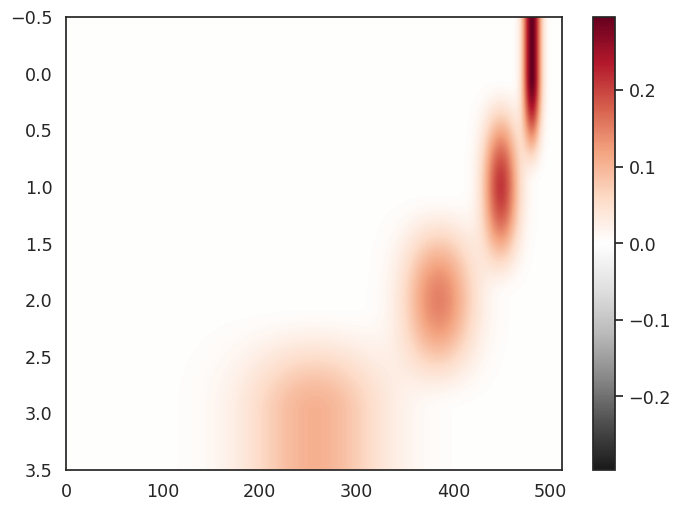

In [11]:
bank_np = torch.squeeze(bank).numpy()
bank_np = np.abs(bank_np)
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(
    bank_np,
    cmap="RdGy_r",
    aspect="auto",
    vmax=abs(bank_np).max(),
    vmin=-abs(bank_np).max(),
)
plt.colorbar()
plt.show()

In [13]:
x = np.random.rand(512, 8, 8)

In [14]:
(bank_np[0, :].reshape(-1, 1, 1) * x).shape

(512, 8, 8)

In [19]:
np.tensordot(bank_np[0, :], x, axes=1).shape

(8, 8)

In [25]:
a = np.arange(32).reshape(4, 1, 2, 2, 2)
A = np.array([10, 20])

In [20]:
a

array([[[[[ 0,  1],
          [ 2,  3]],

         [[ 4,  5],
          [ 6,  7]]]],



       [[[[ 8,  9],
          [10, 11]],

         [[12, 13],
          [14, 15]]]],



       [[[[16, 17],
          [18, 19]],

         [[20, 21],
          [22, 23]]]],



       [[[[24, 25],
          [26, 27]],

         [[28, 29],
          [30, 31]]]]])

In [29]:
a1 = np.transpose(a, (0, 1, 3, 2, 4))
np.dot(A, a1).shape

(4, 1, 2, 2)

In [30]:
a1

array([[[[[ 0,  1],
          [ 4,  5]],

         [[ 2,  3],
          [ 6,  7]]]],



       [[[[ 8,  9],
          [12, 13]],

         [[10, 11],
          [14, 15]]]],



       [[[[16, 17],
          [20, 21]],

         [[18, 19],
          [22, 23]]]],



       [[[[24, 25],
          [28, 29]],

         [[26, 27],
          [30, 31]]]]])

In [31]:
np.dot(A, a1)

array([[[[ 80, 110],
         [140, 170]]],


       [[[320, 350],
         [380, 410]]],


       [[[560, 590],
         [620, 650]]],


       [[[800, 830],
         [860, 890]]]])

In [43]:
at = torch.arange(32).reshape(4, 1, 2, 2, 2)
At = torch.tensor([10, 20])

In [44]:
at

tensor([[[[[ 0,  1],
           [ 2,  3]],

          [[ 4,  5],
           [ 6,  7]]]],



        [[[[ 8,  9],
           [10, 11]],

          [[12, 13],
           [14, 15]]]],



        [[[[16, 17],
           [18, 19]],

          [[20, 21],
           [22, 23]]]],



        [[[[24, 25],
           [26, 27]],

          [[28, 29],
           [30, 31]]]]])

In [45]:
at1 = at.permute(0, 1, 3, 2, 4)
at1

tensor([[[[[ 0,  1],
           [ 4,  5]],

          [[ 2,  3],
           [ 6,  7]]]],



        [[[[ 8,  9],
           [12, 13]],

          [[10, 11],
           [14, 15]]]],



        [[[[16, 17],
           [20, 21]],

          [[18, 19],
           [22, 23]]]],



        [[[[24, 25],
           [28, 29]],

          [[26, 27],
           [30, 31]]]]])

In [47]:
torch.matmul(At, at1)

tensor([[[[ 80, 110],
          [140, 170]]],


        [[[320, 350],
          [380, 410]]],


        [[[560, 590],
          [620, 650]]],


        [[[800, 830],
          [860, 890]]]])